# Image Resconstrute

- Reference : 

1. https://arxiv.org/pdf/2111.12417v1.pdf
2. https://arxiv.org/pdf/2212.06714.pdf

In [75]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

In [141]:
CLASSES_NUM = 10

# Load Dataset

In [140]:
image_net_datasets = tf.keras.datasets.cifar10


# Modeling

In [177]:
input_layer = layers.Input(shape=(256, 256, 3))

x1 = layers.Conv2D(16, (3, 3), strides=2, activation='gelu')(input_layer)
x1_skip2 = x1
x1 = layers.Conv2D(16, (3, 3), activation='gelu')(x1)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Conv2D(16, (3, 3), activation='gelu')(x1)
x1 = layers.BatchNormalization()(x1)

'''First Transformer Block
----------> Start'''
x1 = layers.Conv2D(16, (3, 3), strides=2, activation='gelu')(x1)
x1_skip = layers.Conv2D(16, (3, 3), activation='gelu')(x1)
x1 = layers.DepthwiseConv2D((3, 3), strides=1, activation='gelu')(x1)
x1 = layers.Concatenate()([x1, x1])

x1 = layers.LayerNormalization()(x1)
x2 = layers.Dense(256)(x1)
x1 = layers.DepthwiseConv2D((3, 3), strides=3, activation='gelu')(x1)
x3 = layers.Dense(256)(x1)
x1 = layers.Concatenate()([x1, x3])

x1 = layers.Reshape((76, 76, 18))(x1)
x1 = layers.Conv2D(32, (2, 2), strides=3, activation='gelu')(x1)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Conv2D(32, (2, 2), strides=2, activation='gelu')(x1)
x1 = layers.BatchNormalization()(x1)

x1 = layers.Conv2D(32, (2, 2), strides=2, activation='gelu')(x1)
x1 = layers.BatchNormalization()(x1)
x3_skip = x1
x3_skip = layers.MaxPool2D((2, 2))(x3_skip)

## Guide 
x1 = layers.LayerNormalization()(x1)
x1 = layers.Conv2D(16, (1, 1), strides=2, activation='gelu')(x1)
x1 = layers.BatchNormalization()(x1)
x1 = layers.DepthwiseConv2D((3, 3), strides=1, activation='gelu')(x1)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Conv2D(16, (1, 1), strides=1, activation='gelu')(x1)
x1 = layers.BatchNormalization()(x1)
'''First Transformer Block
----------> End'''

latent_space = x1
latent_space = layers.Flatten()(latent_space)
latent_space = layers.Dense(256, activation='relu')(latent_space)
latent_space = layers.Dense(64, activation='relu')(latent_space)
latent_space = layers.Dense(16, activation='relu')(latent_space)
classification = layers.Dense(CLASSES_NUM, activation='softmax')(latent_space)

'''Second Transformer Block
----------> Start'''
x1 = layers.Conv2DTranspose(32, (3, 3), strides=3, activation='gelu')(x1)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Concatenate()([x1, x3_skip])
x1 = layers.Conv2DTranspose(32, (6, 6), strides=2, activation='gelu')(x1)
x1 = layers.BatchNormalization()(x1)

x1 = layers.Conv2DTranspose(16, (9, 9), strides=2, activation='gelu')(x1)
x1 = layers.Conv2DTranspose(16, (7, 7), strides=2, activation='gelu')(x1)
x1 = layers.Concatenate()([x1, x1_skip])
x1 = layers.BatchNormalization()(x1)
x1 = layers.Conv2DTranspose(16, (4, 4), activation='gelu')(x1)
x1 = layers.BatchNormalization()(x1)

x1 = layers.Conv2DTranspose(16, (5, 5), strides=2, activation='gelu')(x1)
x1 = layers.Concatenate()([x1, x1_skip2])
x1 = layers.LayerNormalization()(x1)

x1 = layers.Conv2DTranspose(8, (3, 3), strides=2, activation='gelu')(x1)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Conv2DTranspose(3, (2, 2), strides=1, activation='gelu')(x1)
x1 = layers.BatchNormalization()(x1)
'''Second Transformer Block
----------> End'''

decoded_image = layers.Reshape((256, 256, 3))(x1)

model = tf.keras.Model(inputs=input_layer, outputs=[classification, decoded_image])
model.summary()

Model: "model_53"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_159 (InputLayer)         [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1015 (Conv2D)           (None, 127, 127, 16  448         ['input_159[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_1016 (Conv2D)           (None, 125, 125, 16  2320        ['conv2d_1015[0][0]']            
                                )                                                          

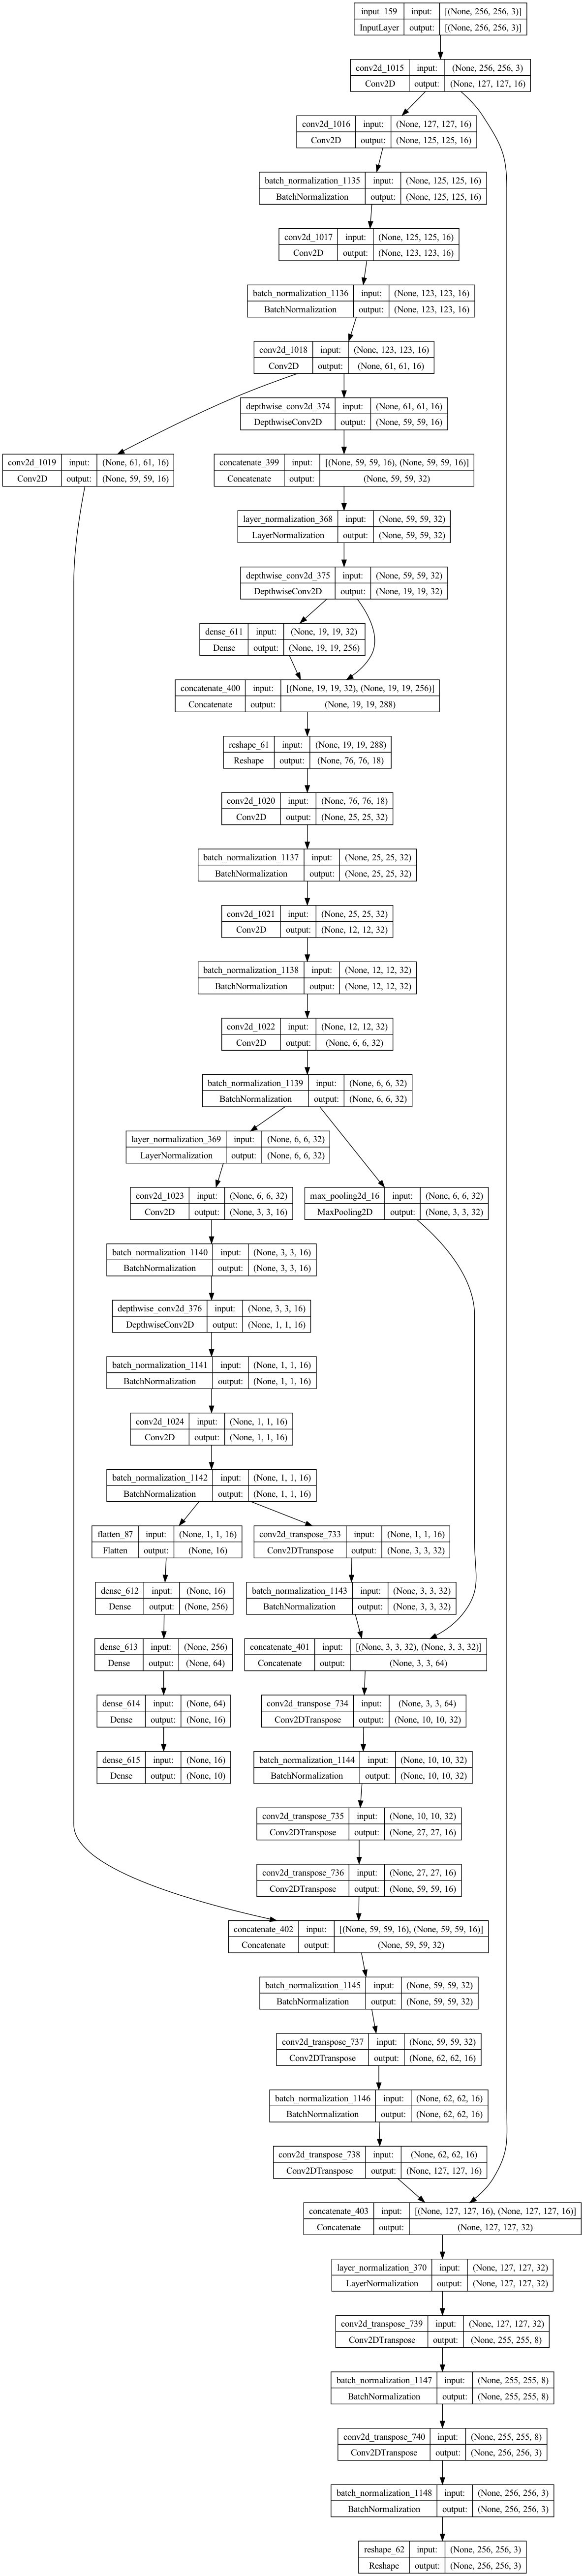

In [178]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [179]:
import visualkeras
visualkeras.layered_view(model, to_file='output.png').show()